In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random

from pre_process import data_prep
from model import forecast_model

In [2]:
path = './Nifty50_dataset/'
for root,dir,files in os.walk(path):
    company_list = files

print("There are {} companies in the Nifty50 dataset.".format(len(company_list)-2))
company_list.remove('stock_metadata.csv')
company_list.remove('NIFTY50_all.csv')
random.shuffle(company_list)
print("Out of which we choose {} for forecasting model".format(company_list[:5]))

There are 50 companies in the Nifty50 dataset.
Out of which we choose ['TECHM.csv', 'HDFCBANK.csv', 'BPCL.csv', 'ADANIPORTS.csv', 'COALINDIA.csv'] for forecasting model


In [3]:
def build_and_evaluate(df):
    processed_data = data_prep(np.array(df.Close),window_size=30)
    train_data = processed_data.pre_process(train=True)
    test_data = processed_data.pre_process(train=False)

    model = forecast_model()
    model = model.build_model()

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)#, momentum=0.9)
    model.compile(loss = tf.keras.losses.Huber(),
                optimizer=optimizer,
                metrics=["mae"])

    print(model.summary())

    history = model.fit(train_data,epochs=50,verbose=False)

    forecast = model.predict(test_data)

    result = forecast[:-1,-1,0]
    result = processed_data.scaler.inverse_transform(result.reshape(1,result.shape[0]))#np.reshape(1,result))
    original = np.array(df['Close'][int(0.8*df.shape[0]):])

    print("MAE between original and forecasted: ",(tf.keras.metrics.mean_absolute_error(original[30:], result)).numpy())

    return history,result,original

    

## Company 1

In [4]:
df = pd.read_csv(path+company_list[0])
print("Sample dataset:\n")
df.head()

Sample dataset:



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2006-08-28,TECHM,EQ,365.00,521.0,569.0,502.00,553.00,554.25,552.00,15166163,8.371760e+14,NaN,3777529,0.2491
1,2006-08-29,TECHM,EQ,554.25,555.0,563.9,535.55,536.10,539.30,547.59,3929113,2.151530e+14,NaN,727534,0.1852
2,2006-08-30,TECHM,EQ,539.30,537.0,542.9,521.50,529.00,528.10,529.55,2034983,1.077630e+14,NaN,345064,0.1696
3,2006-08-31,TECHM,EQ,528.10,525.0,544.0,515.00,539.35,538.45,532.89,1670990,8.904464e+13,NaN,286440,0.1714
4,2006-09-01,TECHM,EQ,538.45,539.0,549.0,535.10,541.35,541.85,542.46,1176195,6.380386e+13,NaN,213842,0.1818


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

print("There are total {} datapoints for {}".format(df.shape[0],company_list[0]))
print("The data is from {} to {} ".format(df.Date[0],df.Date[df.shape[0]-1]))
print("The highest closing value for this company was {} on {}".format(np.max(df.Close),df.loc[df['Close']==np.max(df.Close),'Date']))
print("The lowest closing value for this company was {} on {}".format(np.min(df.Close),df.loc[df['Close']==np.min(df.Close),'Date']))

There are total 3635 datapoints for TECHM.csv
The data is from 2006-08-28 00:00:00 to 2021-04-30 00:00:00 
The highest closing value for this company was 2921.65 on 2116   2015-03-11
Name: Date, dtype: datetime64[ns]
The lowest closing value for this company was 209.3 on 597   2009-01-23
Name: Date, dtype: datetime64[ns]


Text(0.5, 1.0, 'Daily closing price of TECHM')

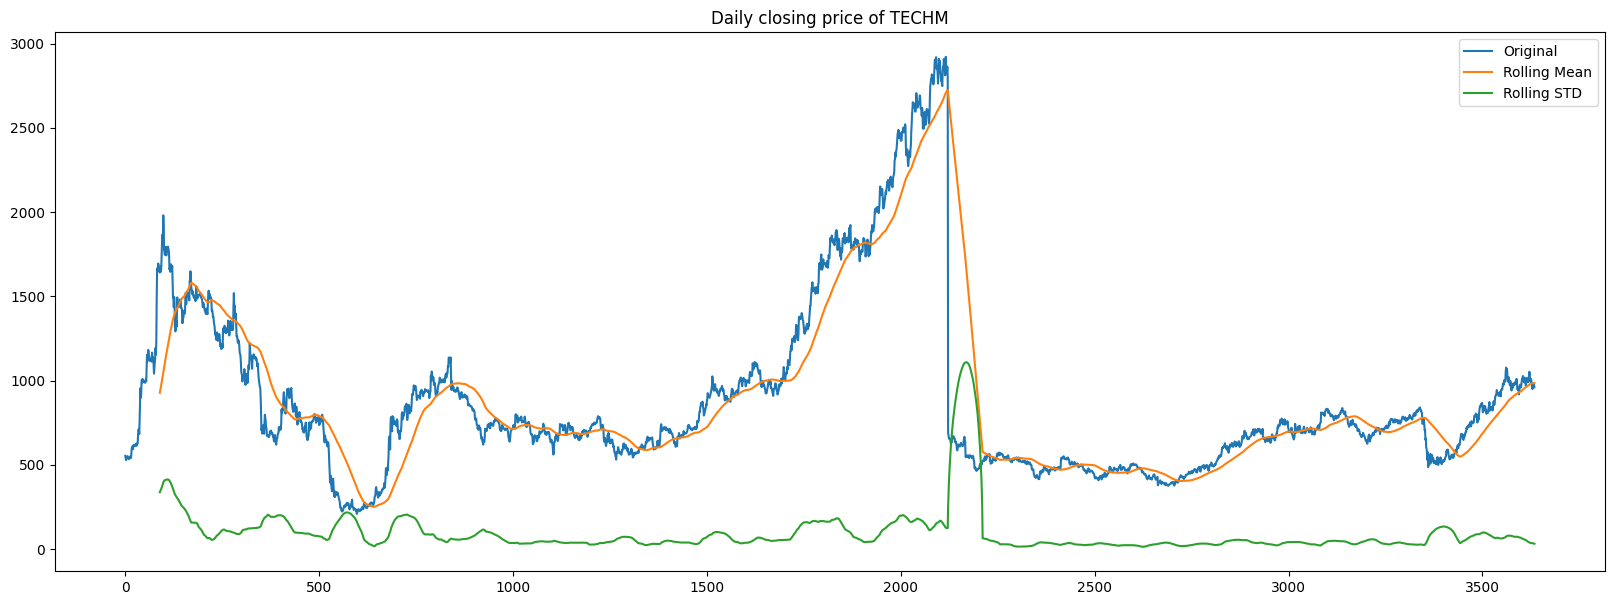

In [6]:
plt.figure(figsize=(20,7))
plt.plot(df['Close'],label='Original')
plt.plot(df['Close'].rolling(window=90).mean(),label='Rolling Mean')
plt.plot(df['Close'].rolling(window=90).std(),label='Rolling STD')
plt.legend(loc='best')
plt.title("Daily closing price of {}".format(company_list[0][:-4]))

In [7]:
history,result, original = build_and_evaluate(df)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 64)          384       
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, None, 128)         98816     
                                                                 
 dense_3 (Dense)             (None, None, 30)          3870      
                                                                 
 dense_4 (Dense)             (None, None, 10)          310       
                                                                 
 dense_5 (Dense)             (None, None, 1)           11        
                                                                 
Total params: 136,415
Trainable params: 136,415
Non-tr

2022-10-21 01:50:31.401107: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 1s 17ms/step
MAE between original and forecasted:  [78.01814]


Training Summary

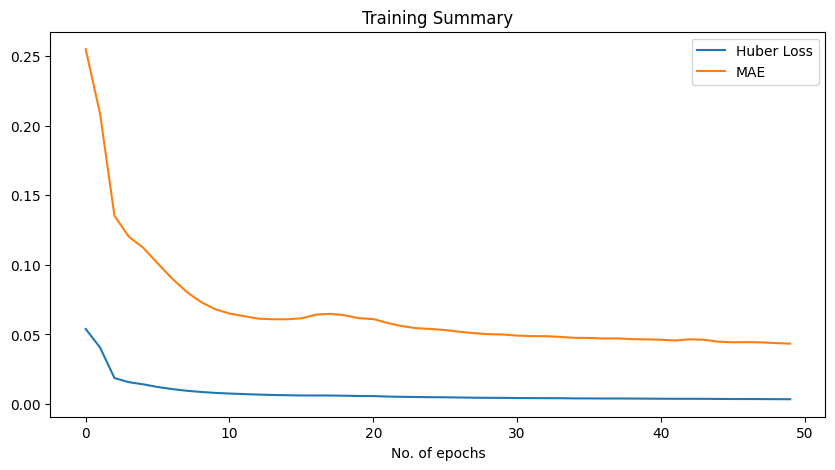

In [8]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label="Huber Loss")
plt.plot(history.history['mae'],label='MAE')
plt.xlabel("No. of epochs")
plt.title("Training Summary")
plt.legend(loc='best')

Test summary

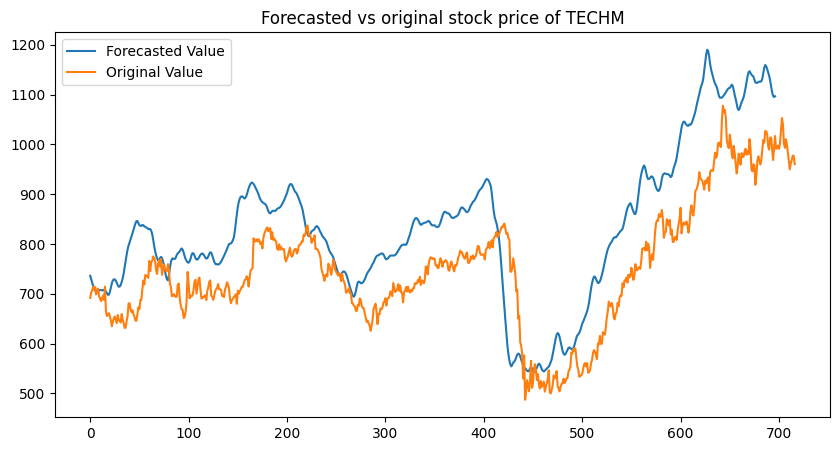

In [9]:
plt.figure(figsize=(10,5))
plt.plot(result[0],label="Forecasted Value")
plt.plot(original[10:],label='Original Value')
plt.title("Forecasted vs original stock price of {}".format(company_list[0][:-4]))
plt.legend(loc='best')
file_name = "images/results_"+company_list[0][:-4]+".png"
plt.savefig(file_name)


## Company 2

In [10]:
df = pd.read_csv(path+company_list[1])
print("Sample dataset:\n")
df.head()

Sample dataset:



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,HDFCBANK,EQ,157.40,166.00,170.00,166.00,170.00,170.00,169.52,33259,5.638122e+11,NaN,NaN,NaN
1,2000-01-04,HDFCBANK,EQ,170.00,182.00,183.45,171.00,174.00,173.80,174.99,168710,2.952261e+12,NaN,NaN,NaN
2,2000-01-05,HDFCBANK,EQ,173.80,170.00,173.90,165.00,168.00,166.95,169.20,159820,2.704094e+12,NaN,NaN,NaN
3,2000-01-06,HDFCBANK,EQ,166.95,168.00,170.00,165.30,168.95,168.30,168.44,85026,1.432166e+12,NaN,NaN,NaN
4,2000-01-07,HDFCBANK,EQ,168.30,162.15,171.00,162.15,170.75,168.35,166.79,85144,1.420158e+12,NaN,NaN,NaN


In [11]:
df['Date'] = pd.to_datetime(df['Date'])

print("There are total {} datapoints for {}".format(df.shape[0],company_list[1]))
print("The data is from {} to {} ".format(df.Date[0],df.Date[df.shape[0]-1]))
print("The highest closing value for this company was {} on {}".format(np.max(df.Close),df.loc[df['Close']==np.max(df.Close),'Date']))
print("The lowest closing value for this company was {} on {}".format(np.min(df.Close),df.loc[df['Close']==np.min(df.Close),'Date']))

There are total 5306 datapoints for HDFCBANK.csv
The data is from 2000-01-03 00:00:00 to 2021-04-30 00:00:00 
The highest closing value for this company was 2565.8 on 2876   2011-07-07
Name: Date, dtype: datetime64[ns]
The lowest closing value for this company was 163.4 on 6   2000-01-11
Name: Date, dtype: datetime64[ns]


Text(0.5, 1.0, 'Daily closing price of HDFCBANK')

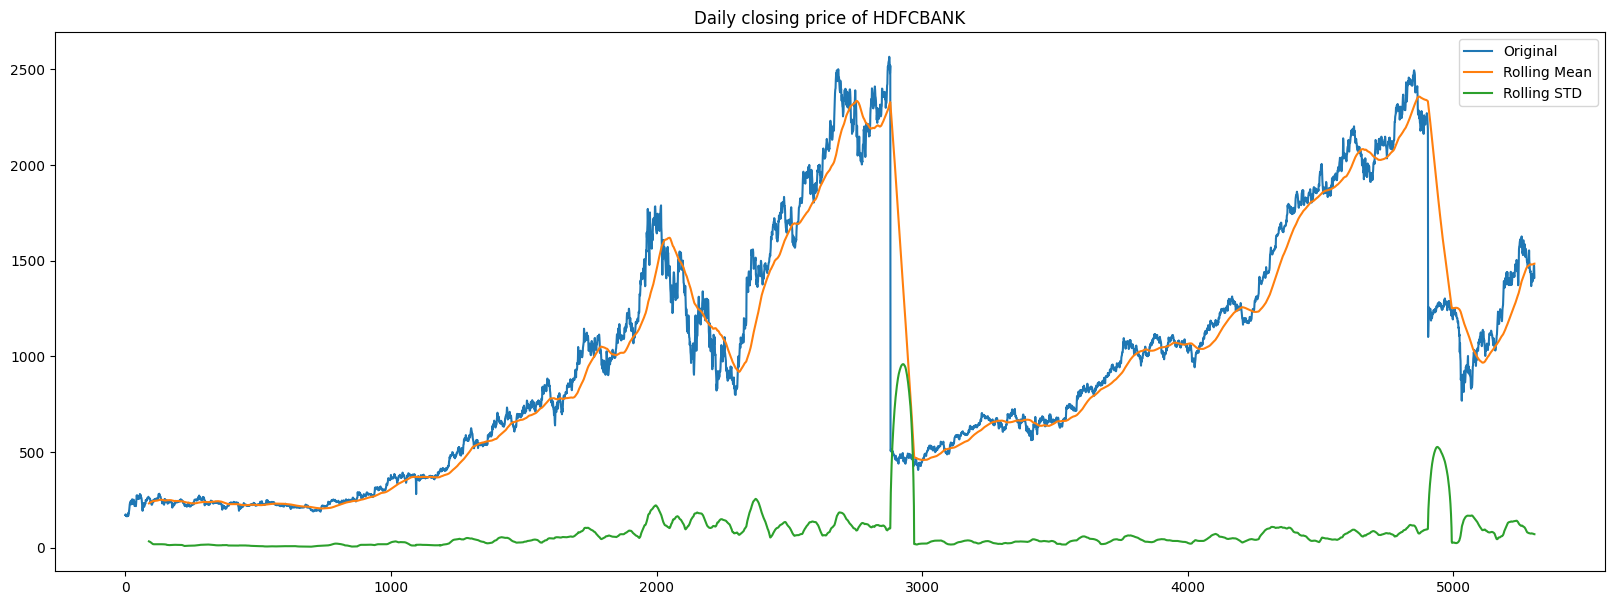

In [12]:
plt.figure(figsize=(20,7))
plt.plot(df['Close'],label='Original')
plt.plot(df['Close'].rolling(window=90).mean(),label='Rolling Mean')
plt.plot(df['Close'].rolling(window=90).std(),label='Rolling STD')
plt.legend(loc='best')
plt.title("Daily closing price of {}".format(company_list[1][:-4]))

In [13]:
history,result, original = build_and_evaluate(df)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 64)          384       
                                                                 
 lstm_6 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_7 (LSTM)               (None, None, 128)         98816     
                                                                 
 dense_9 (Dense)             (None, None, 30)          3870      
                                                                 
 dense_10 (Dense)            (None, None, 10)          310       
                                                                 
 dense_11 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 136,415
Trainable params: 136,415
Non-tr

Training Summary

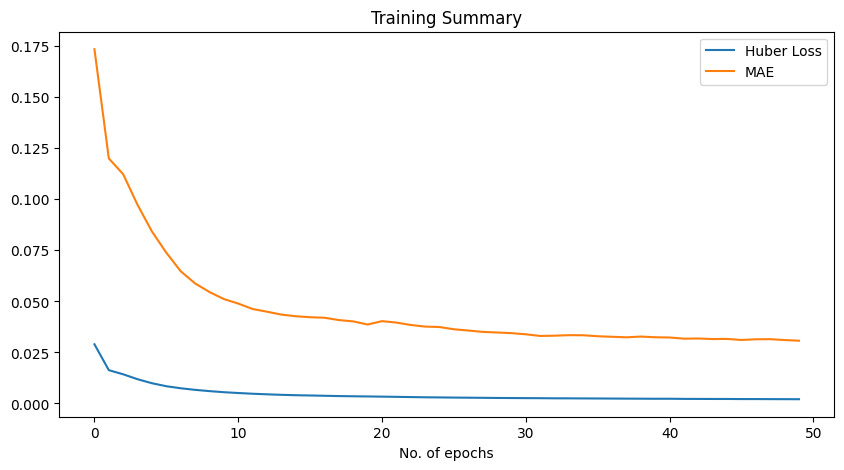

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label="Huber Loss")
plt.plot(history.history['mae'],label='MAE')
plt.xlabel("No. of epochs")
plt.title("Training Summary")
plt.legend(loc='best')

Test summary

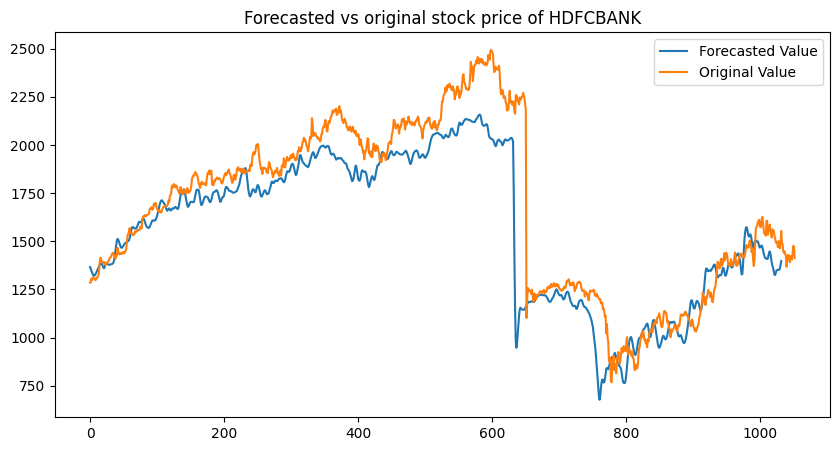

In [15]:
plt.figure(figsize=(10,5))
plt.plot(result[0],label="Forecasted Value")
plt.plot(original[10:],label='Original Value')
plt.title("Forecasted vs original stock price of {}".format(company_list[1][:-4]))
plt.legend(loc='best')
file_name = "images/results_"+company_list[1][:-4]+".png"
plt.savefig(file_name)


## Company 3

In [16]:
df = pd.read_csv(path+company_list[2])
print("Sample dataset:\n")
df.head()

Sample dataset:



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,BPCL,EQ,381.20,405.00,407.00,393.05,397.75,399.25,399.32,8720,3.482029e+11,NaN,NaN,NaN
1,2000-01-04,BPCL,EQ,399.25,397.75,397.75,367.40,377.45,370.50,375.71,22820,8.573699e+11,NaN,NaN,NaN
2,2000-01-05,BPCL,EQ,370.50,350.00,385.00,350.00,360.10,359.95,359.96,152538,5.490785e+12,NaN,NaN,NaN
3,2000-01-06,BPCL,EQ,359.95,362.00,384.00,362.00,381.65,380.30,380.10,59554,2.263623e+12,NaN,NaN,NaN
4,2000-01-07,BPCL,EQ,380.30,369.00,390.00,366.00,381.50,379.85,378.33,43187,1.633890e+12,NaN,NaN,NaN


In [17]:
df['Date'] = pd.to_datetime(df['Date'])

print("There are total {} datapoints for {}".format(df.shape[0],company_list[2]))
print("The data is from {} to {} ".format(df.Date[0],df.Date[df.shape[0]-1]))
print("The highest closing value for this company was {} on {}".format(np.max(df.Close),df.loc[df['Close']==np.max(df.Close),'Date']))
print("The lowest closing value for this company was {} on {}".format(np.min(df.Close),df.loc[df['Close']==np.min(df.Close),'Date']))

There are total 5306 datapoints for BPCL.csv
The data is from 2000-01-03 00:00:00 to 2021-04-30 00:00:00 
The highest closing value for this company was 1133.3 on 4116   2016-07-11
Name: Date, dtype: datetime64[ns]
The lowest closing value for this company was 110.15 on 246   2000-12-26
Name: Date, dtype: datetime64[ns]


Text(0.5, 1.0, 'Daily closing price of BPCL')

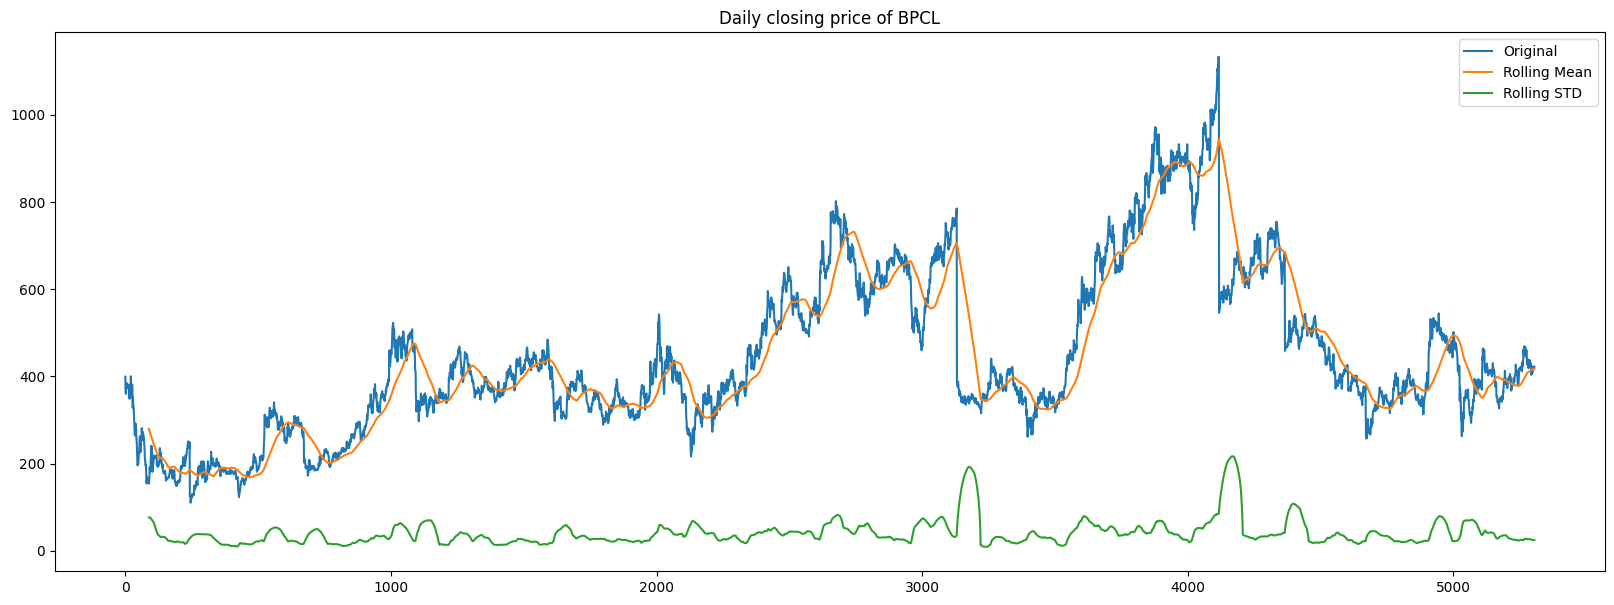

In [18]:
plt.figure(figsize=(20,7))
plt.plot(df['Close'],label='Original')
plt.plot(df['Close'].rolling(window=90).mean(),label='Rolling Mean')
plt.plot(df['Close'].rolling(window=90).std(),label='Rolling STD')
plt.legend(loc='best')
plt.title("Daily closing price of {}".format(company_list[2][:-4]))

In [19]:
history,result, original = build_and_evaluate(df)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 64)          384       
                                                                 
 lstm_10 (LSTM)              (None, None, 64)          33024     
                                                                 
 lstm_11 (LSTM)              (None, None, 128)         98816     
                                                                 
 dense_15 (Dense)            (None, None, 30)          3870      
                                                                 
 dense_16 (Dense)            (None, None, 10)          310       
                                                                 
 dense_17 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 136,415
Trainable params: 136,415
Non-tr

Training Summary

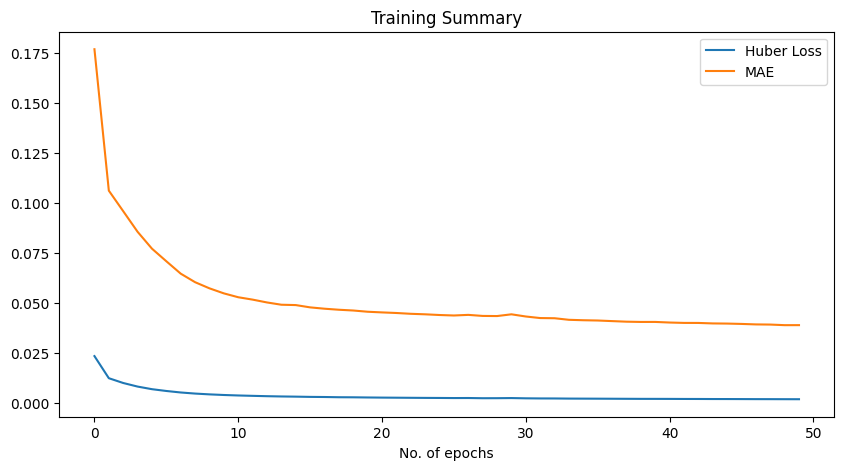

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label="Huber Loss")
plt.plot(history.history['mae'],label='MAE')
plt.xlabel("No. of epochs")
plt.title("Training Summary")
plt.legend(loc='best')

Test summary

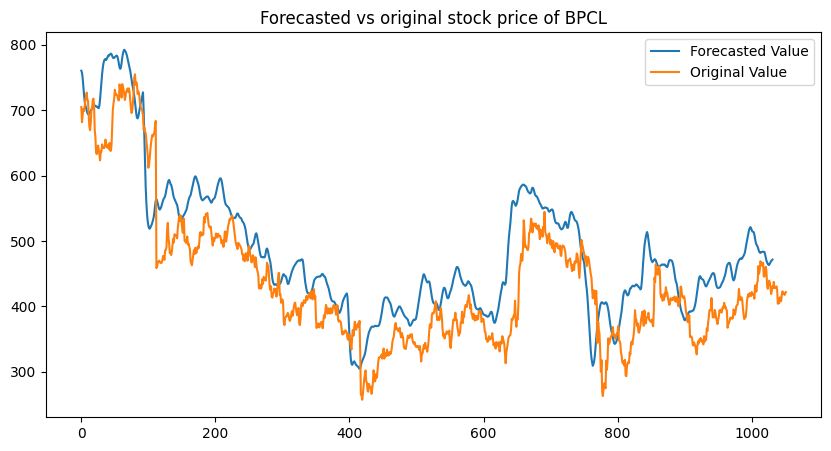

In [21]:
plt.figure(figsize=(10,5))
plt.plot(result[0],label="Forecasted Value")
plt.plot(original[10:],label='Original Value')
plt.title("Forecasted vs original stock price of {}".format(company_list[2][:-4]))
plt.legend(loc='best')
file_name = "images/results_"+company_list[2][:-4]+".png"
plt.savefig(file_name)


## Copmpany 4

In [22]:
df = pd.read_csv(path+company_list[3])
print("Sample dataset:\n")
df.head()

Sample dataset:



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123,0.2741


In [23]:
df['Date'] = pd.to_datetime(df['Date'])

print("There are total {} datapoints for {}".format(df.shape[0],company_list[3]))
print("The data is from {} to {} ".format(df.Date[0],df.Date[df.shape[0]-1]))
print("The highest closing value for this company was {} on {}".format(np.max(df.Close),df.loc[df['Close']==np.max(df.Close),'Date']))
print("The lowest closing value for this company was {} on {}".format(np.min(df.Close),df.loc[df['Close']==np.min(df.Close),'Date']))

There are total 3322 datapoints for ADANIPORTS.csv
The data is from 2007-11-27 00:00:00 to 2021-04-30 00:00:00 
The highest closing value for this company was 1307.45 on 24   2008-01-02
Name: Date, dtype: datetime64[ns]
The lowest closing value for this company was 108.0 on 1176   2012-08-27
Name: Date, dtype: datetime64[ns]


Text(0.5, 1.0, 'Daily closing price of ADANIPORTS')

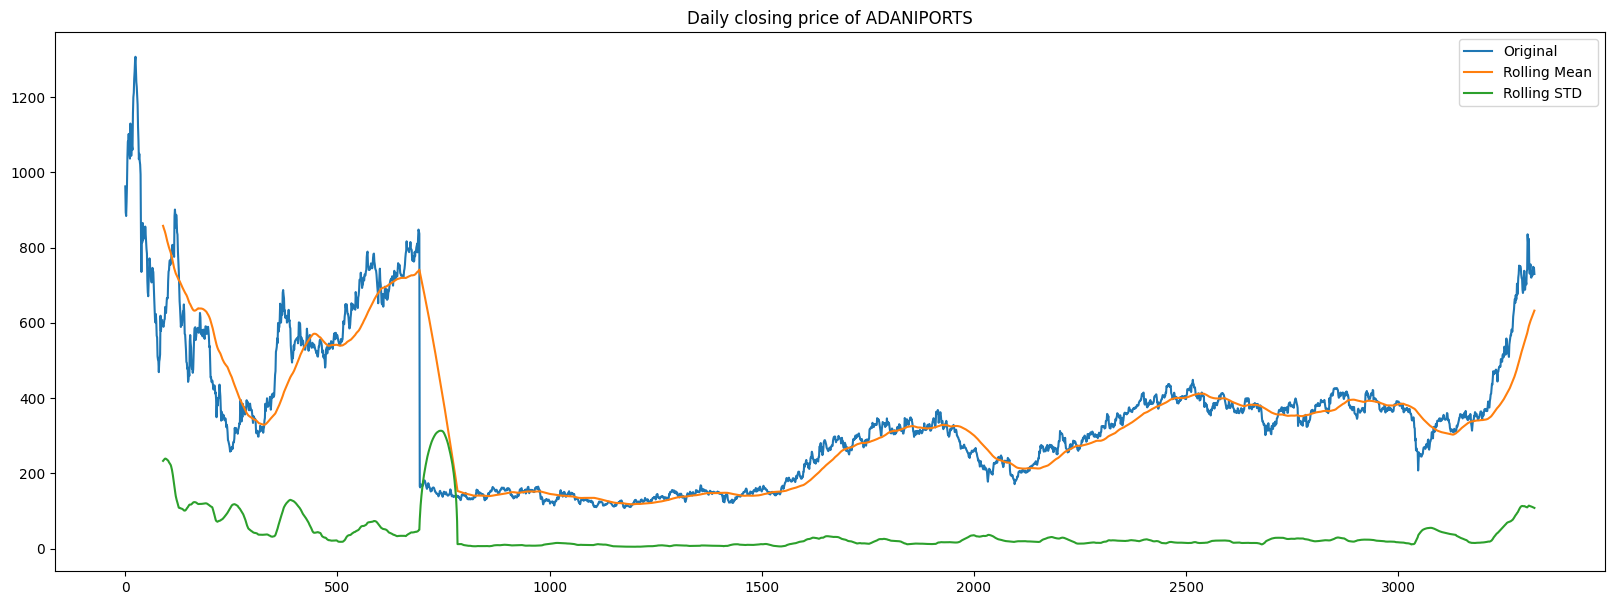

In [24]:
plt.figure(figsize=(20,7))
plt.plot(df['Close'],label='Original')
plt.plot(df['Close'].rolling(window=90).mean(),label='Rolling Mean')
plt.plot(df['Close'].rolling(window=90).std(),label='Rolling STD')
plt.legend(loc='best')
plt.title("Daily closing price of {}".format(company_list[3][:-4]))

In [25]:
history,result, original = build_and_evaluate(df)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, None, 64)          384       
                                                                 
 lstm_14 (LSTM)              (None, None, 64)          33024     
                                                                 
 lstm_15 (LSTM)              (None, None, 128)         98816     
                                                                 
 dense_21 (Dense)            (None, None, 30)          3870      
                                                                 
 dense_22 (Dense)            (None, None, 10)          310       
                                                                 
 dense_23 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 136,415
Trainable params: 136,415
Non-tr

Training Summary

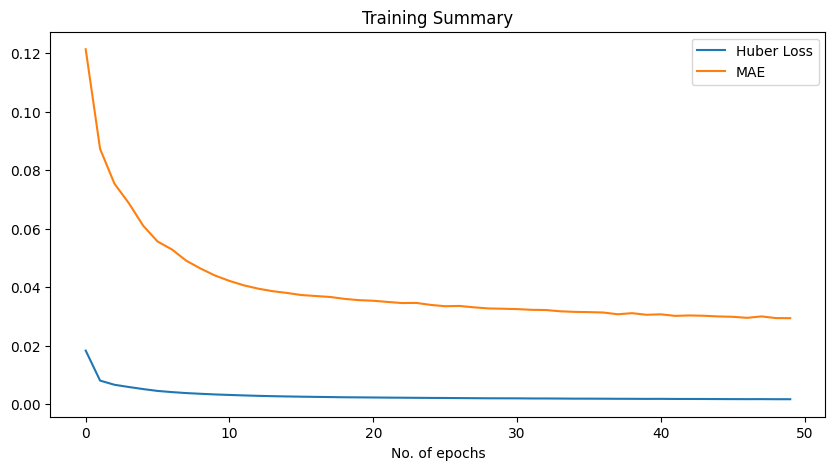

In [26]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label="Huber Loss")
plt.plot(history.history['mae'],label='MAE')
plt.xlabel("No. of epochs")
plt.title("Training Summary")
plt.legend(loc='best')

Test summary

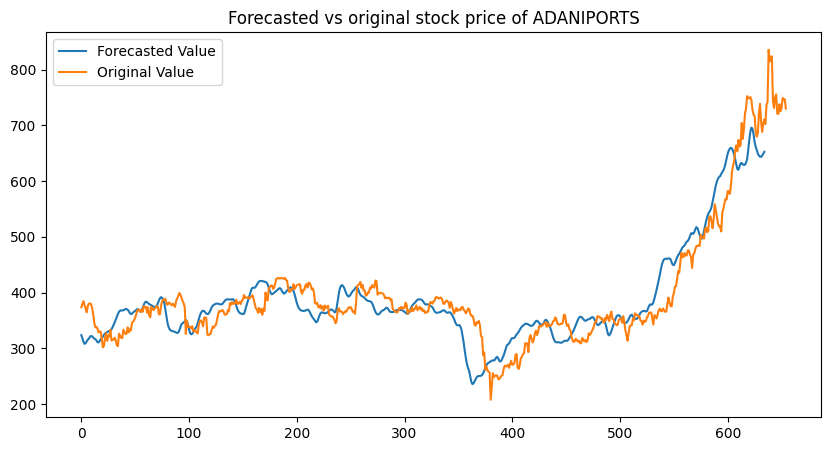

In [27]:
plt.figure(figsize=(10,5))
plt.plot(result[0],label="Forecasted Value")
plt.plot(original[10:],label='Original Value')
plt.title("Forecasted vs original stock price of {}".format(company_list[3][:-4]))
plt.legend(loc='best')
file_name = "images/results_"+company_list[3][:-4]+".png"
plt.savefig(file_name)


## Company 5

In [28]:
df = pd.read_csv(path+company_list[4])
print("Sample dataset:\n")
df.head()

Sample dataset:



,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2010-11-04,COALINDIA,EQ,245.00,291.00,344.9,291.00,342.0,342.55,327.29,479716245,1.570040e+16,NaN,187584905,0.3910
1,2010-11-05,COALINDIA,EQ,342.55,343.00,356.5,343.00,348.3,349.85,349.78,31927173,1.116747e+15,NaN,10894509,0.3412
2,2010-11-08,COALINDIA,EQ,349.85,351.80,355.9,329.50,331.4,330.75,335.19,46932779,1.573118e+15,NaN,16651623,0.3548
3,2010-11-09,COALINDIA,EQ,330.75,330.15,333.4,325.00,325.4,326.05,327.75,23741956,7.781383e+14,NaN,12977359,0.5466
4,2010-11-10,COALINDIA,EQ,326.05,325.40,327.8,320.05,321.3,322.80,323.78,21057129,6.817982e+14,NaN,6280335,0.2983


In [29]:
df['Date'] = pd.to_datetime(df['Date'])

print("There are total {} datapoints for {}".format(df.shape[0],company_list[4]))
print("The data is from {} to {} ".format(df.Date[0],df.Date[df.shape[0]-1]))
print("The highest closing value for this company was {} on {}".format(np.max(df.Close),df.loc[df['Close']==np.max(df.Close),'Date']))
print("The lowest closing value for this company was {} on {}".format(np.min(df.Close),df.loc[df['Close']==np.min(df.Close),'Date']))

There are total 2598 datapoints for COALINDIA.csv
The data is from 2010-11-04 00:00:00 to 2021-04-30 00:00:00 
The highest closing value for this company was 443.4 on 1179   2015-08-04
Name: Date, dtype: datetime64[ns]
The lowest closing value for this company was 110.55 on 2463   2020-10-14
Name: Date, dtype: datetime64[ns]


Text(0.5, 1.0, 'Daily closing price of COALINDIA')

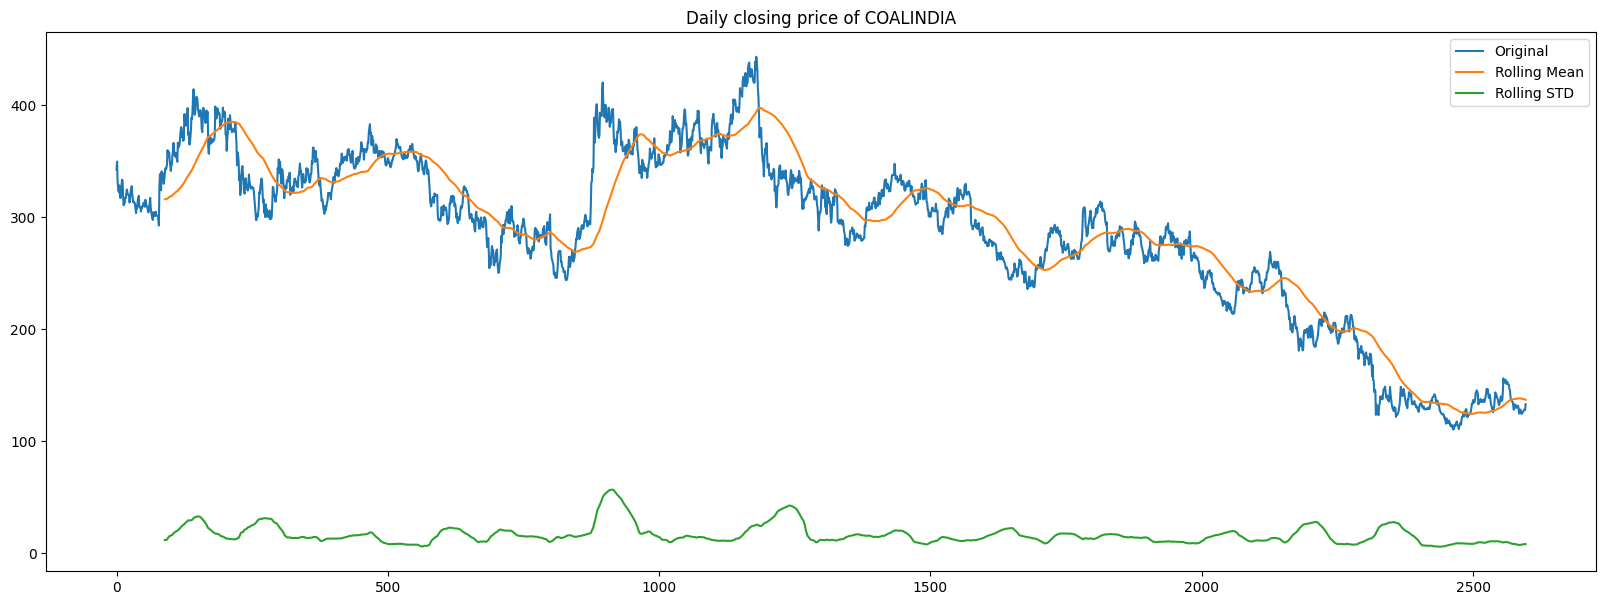

In [30]:
plt.figure(figsize=(20,7))
plt.plot(df['Close'],label='Original')
plt.plot(df['Close'].rolling(window=90).mean(),label='Rolling Mean')
plt.plot(df['Close'].rolling(window=90).std(),label='Rolling STD')
plt.legend(loc='best')
plt.title("Daily closing price of {}".format(company_list[4][:-4]))

In [31]:
history,result, original = build_and_evaluate(df)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, None, 64)          384       
                                                                 
 lstm_18 (LSTM)              (None, None, 64)          33024     
                                                                 
 lstm_19 (LSTM)              (None, None, 128)         98816     
                                                                 
 dense_27 (Dense)            (None, None, 30)          3870      
                                                                 
 dense_28 (Dense)            (None, None, 10)          310       
                                                                 
 dense_29 (Dense)            (None, None, 1)           11        
                                                                 
Total params: 136,415
Trainable params: 136,415
Non-tr

Training Summary

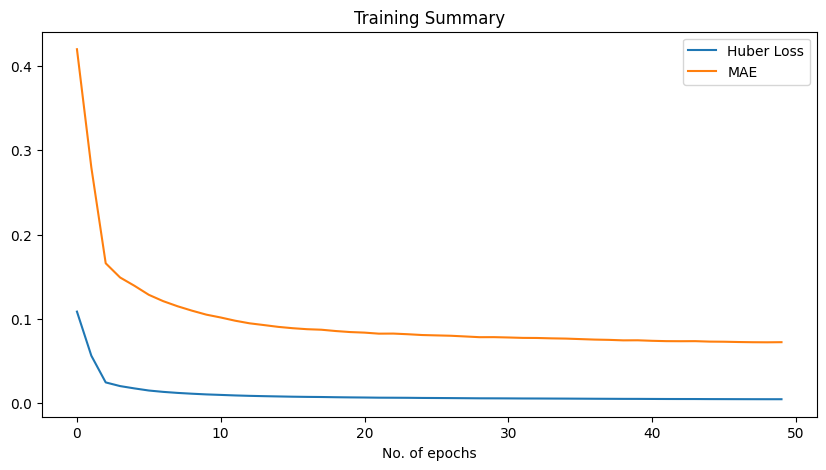

In [32]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label="Huber Loss")
plt.plot(history.history['mae'],label='MAE')
plt.xlabel("No. of epochs")
plt.title("Training Summary")
plt.legend(loc='best')

Test summary

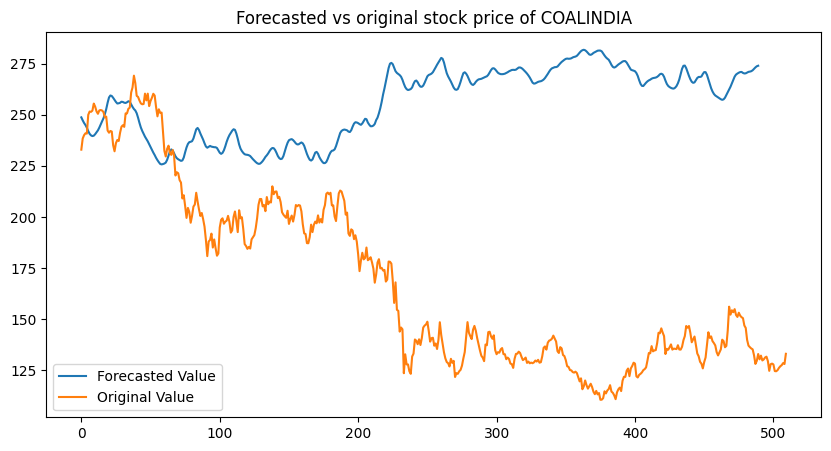

In [33]:
plt.figure(figsize=(10,5))
plt.plot(result[0],label="Forecasted Value")
plt.plot(original[10:],label='Original Value')
plt.title("Forecasted vs original stock price of {}".format(company_list[4][:-4]))
plt.legend(loc='best')
file_name = "images/results_"+company_list[4][:-4]+".png"
plt.savefig(file_name)
